In [2]:
# импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**Проведите предварительную обработку данных, включая обработку отсутствующих значений, кодирование категориальных признаков и масштабирование.**

In [3]:
# считывание данных
data = pd.read_csv('diabetes.csv')

In [4]:
# показывает информацию о наборе данных и т.д.
data.info()
# для просмотря статистической сводки каждого стобца
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   Pedigree       768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Визуализация**

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'Pedigree'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

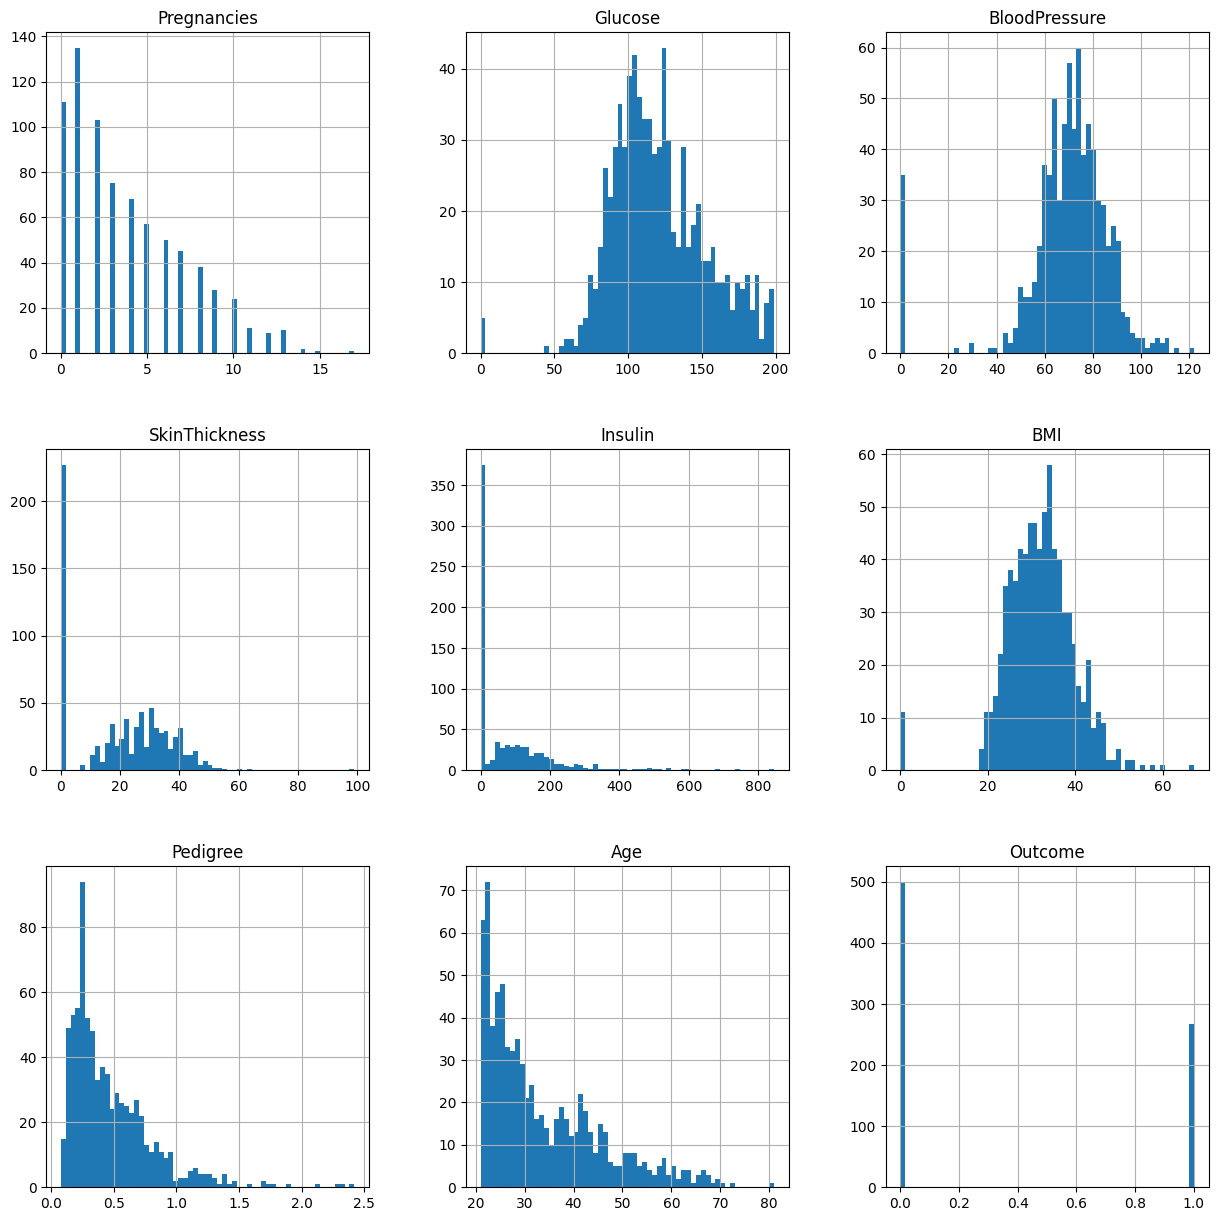

In [5]:
data.hist(bins=60, figsize=(15, 15))

In [6]:
# Нормировка данных (приведение к единому масштабу)
def standardize_data(data, excluded_columns=[]):
    standardized_data = data.copy()
    for column in data.columns:

        if column not in excluded_columns:
            column_min = np.min(data[column])
            column_max = np.max(data[column])
            standardized_data[column] = (data[column] - column_min) / (column_max - column_min)
        else:
            mean = np.mean(data[column], axis=0)

            # стандартное отклонение
            std = np.std(data[column], axis=0)

            standardized_data[column] = (data[column] - mean) / std
    return standardize_data

X = standardize_data(data)

In [7]:
# Определяем зависимую переменную (целевую) и признаки
X = data.drop(columns = ["Outcome"])
y = data["Outcome"]

In [8]:
# Разделение на обучающий и тестовый наборы
def train_test_split_custom(X, y, test_size=0.2):
    # Вычисляем количество элементов, которые нужно выделить на тестовый набор
    test_samples = int(len(X) * test_size)
    # Получаем случайные индексы для тестового набора
    test_indices = np.random.choice(len(X), test_samples, replace=False)
    # Создаем маску для индексов, которые будут использоваться в тренировочном наборе
    train_indices = np.ones(len(X), dtype=bool)
    train_indices[test_indices] = False
    # Разделяем данные на тренировочный и тестовый наборы
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_size=0.2)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()
y_test.shape

(153,)

**Реализуйте метод k-ближайших соседей без использования сторонних библиотек, кроме NumPy и Pandas.**

In [9]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # Наиболее частый класс
    def most_common(self, y):
        labels = np.unique(y)
        count = [list(y).count(i) for i in labels]
        return labels[np.argmax(count)]

    def predict(self, X_test):
        # Предсказываем метки классов
        labels = [self.find_labels(x) for x in X_test]
        return np.array(labels)

    def find_labels(self, x):
        # Считаем расстояние
        distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]
        # Берем индексы наблюдений
        k_nearest = np.argsort(distances)[:self.k]
        # По индексам берем метки классов
        labels = [self.y_train[i] for i in k_nearest]
        return self.most_common(labels)


In [10]:
def f1_score(y_test, pred):
    # Classes = [TP, FP, TN, FN]
    y_test = y_test.flatten()
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    classes = list(set(y_test.tolist()))
    classes_stats = [[0, 0, 0, 0]] * len(classes)
    for i, cur_class in enumerate(classes):
        for idx, (el1, el2) in enumerate(zip(y_test, pred)):
            if (el1 == el2 == cur_class):
                TP += 1
                classes_stats[i][0] += 1
            if (el2 == cur_class and el1 != el2):
                FP += 1
                classes_stats[i][1] += 1
            if (el1 == el2 and el1 != cur_class):
                classes_stats[i][2] += 1
                TN += 1
            if (el1 != el2 and el1 != cur_class):
                classes_stats[i][3] += 1
                FN += 1
    
    precision = TP/(TP+FP) 
    recall = TP/(TP+FN) 
        
    return 2 * (precision * recall) / (precision + recall)

In [11]:
def confusion_matrix(y_test, pred):
	#Classes = [TP, FP, TN, FN]
	y_test = y_test.flatten()
	TP = 0
	FP = 0
	TN = 0
	FN = 0

	classes = list(set(y_test.tolist()))
	num_classes = len(classes)
	confusion_matrix = np.zeros((num_classes, num_classes))
	for true_label, predicted_label in zip(y_test, pred):
		true_label_index = classes.index(true_label)
		predicted_label_index = classes.index(predicted_label)
		confusion_matrix[true_label_index][predicted_label_index] += 1

	return confusion_matrix

In [12]:
def show_cf_matrix(cf_matrix):
  fig, AX = plt.subplots(figsize=(3, 2))
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Purples')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.xaxis.set_ticklabels(['1','2'])
  ax.yaxis.set_ticklabels(['1','2'])

  plt.show()

**Постройте две модели k-NN с различными наборами признаков:**

  *- Модель 1: Признаки случайно отбираются .*
  
  *- Модель 2: Фиксированный набор признаков, который выбирается заранее.*

['Insulin', 'BMI', 'BloodPressure']


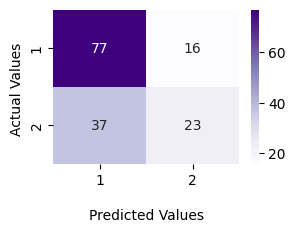

0.6535947712418301


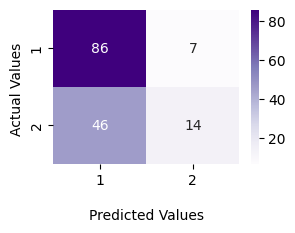

0.6535947712418301


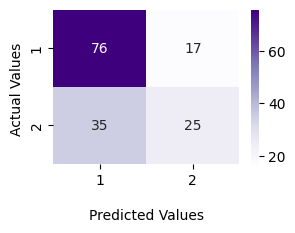

0.6601307189542484


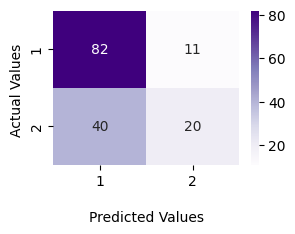

0.6666666666666666


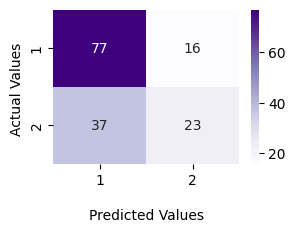

0.6535947712418301


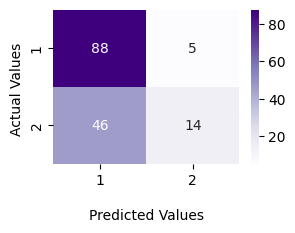

0.6666666666666666


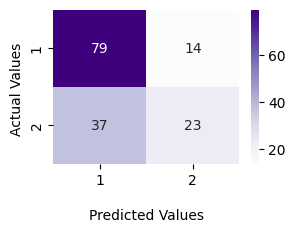

0.6666666666666666


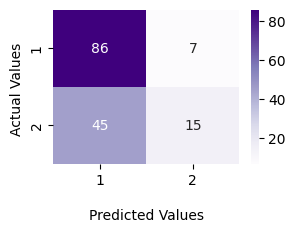

0.6601307189542484


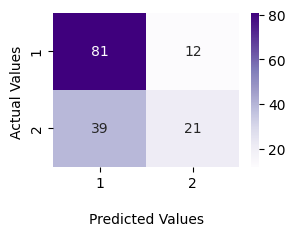

0.6666666666666666


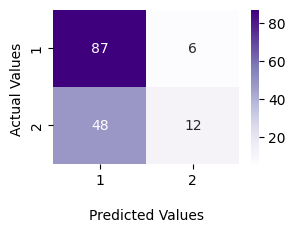

0.6470588235294118


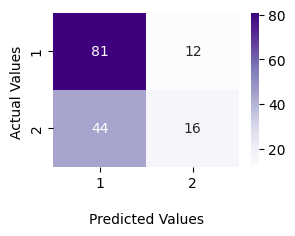

0.6339869281045751


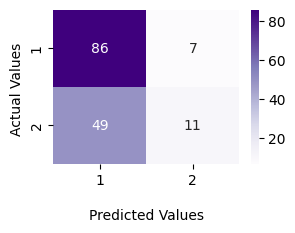

0.6339869281045751


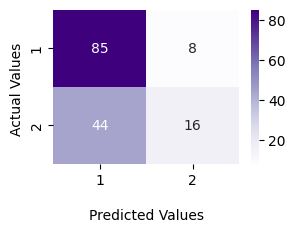

0.6601307189542484


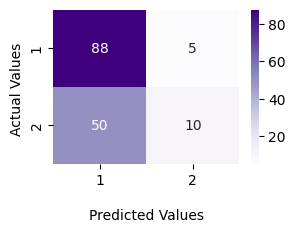

0.6405228758169934


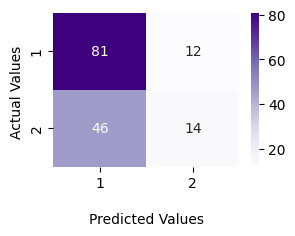

0.6209150326797386


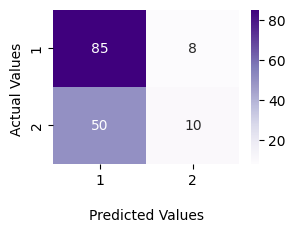

0.6209150326797386


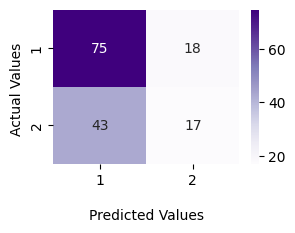

0.6013071895424836


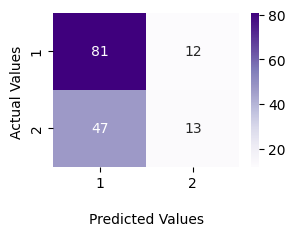

0.6143790849673203


<function matplotlib.pyplot.show(close=None, block=None)>

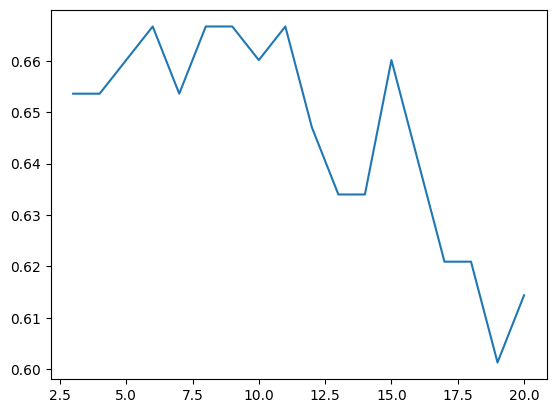

In [13]:
# Модель со случайными признаками
tags = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "Pedigree", "Age"]
n = random.randint(1,8)
tags_1 = random.sample(tags, n)
print(tags_1)

X_test_rand = X_test[tags_1]
X_train_rand = X_train[tags_1]
X_test_rand=X_test_rand.to_numpy()
X_train_rand = X_train_rand.to_numpy()
k=[]
test_score = []
for i in range(3,21,1):
  clf = KNN(k=i)
  clf.fit(X_train_rand,y_train_np)
  y_pred = clf.predict(X_test_rand)
  show_cf_matrix(confusion_matrix(y_test_np, y_pred))
  print(f1_score(y_test_np,y_pred))
  test_score.append(f1_score(y_test_np,y_pred))
  k.append(i)

plt.plot(k,test_score)
plt.show

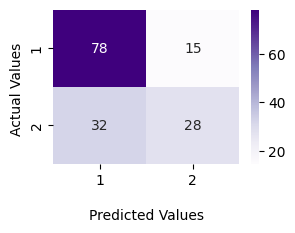

0.6928104575163399


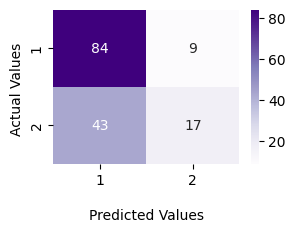

0.6601307189542484


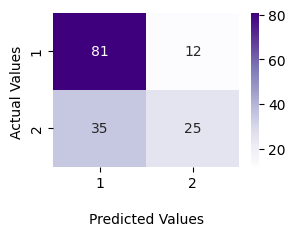

0.6928104575163399


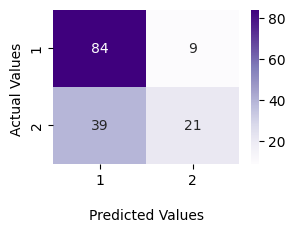

0.6862745098039216


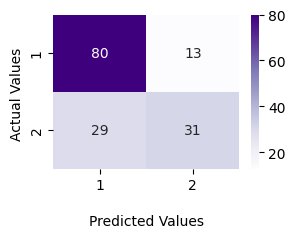

0.7254901960784313


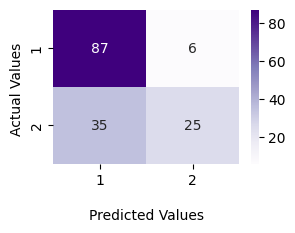

0.7320261437908496


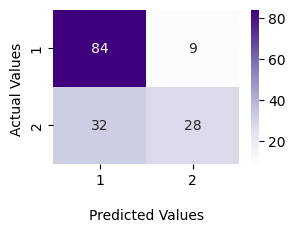

0.7320261437908496


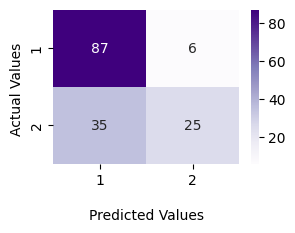

0.7320261437908496


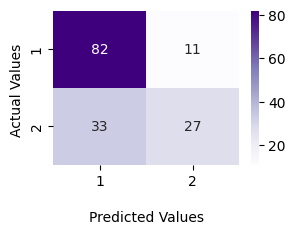

0.7124183006535948


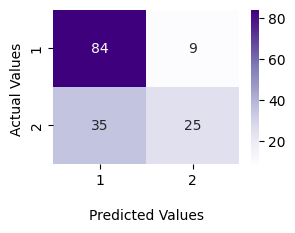

0.7124183006535948


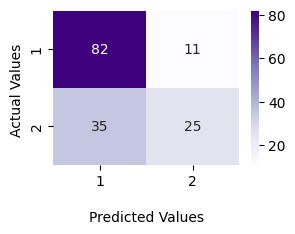

0.6993464052287581


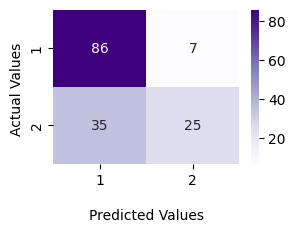

0.7254901960784313


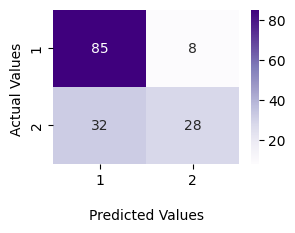

0.738562091503268


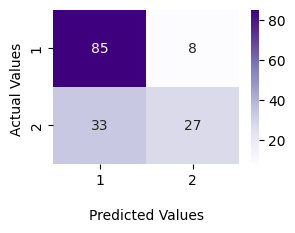

0.7320261437908496


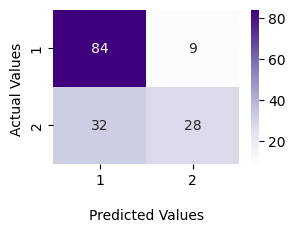

0.7320261437908496


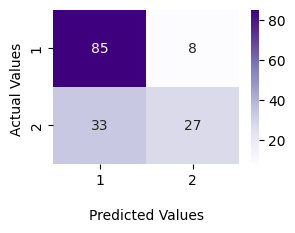

0.7320261437908496


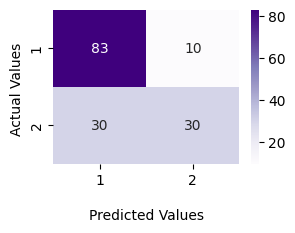

0.738562091503268


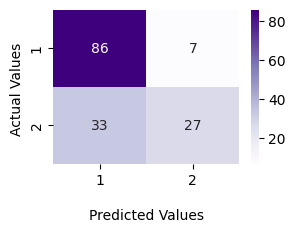

0.738562091503268


<function matplotlib.pyplot.show(close=None, block=None)>

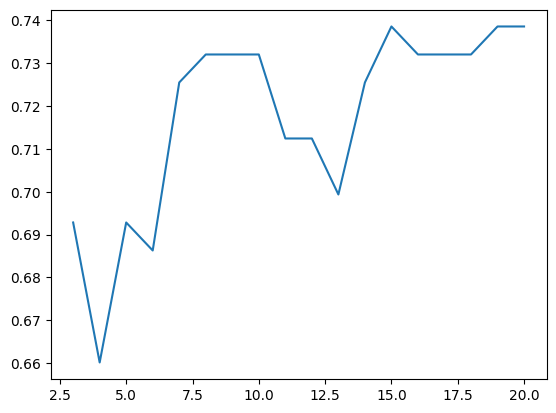

In [14]:
# Модель с фиксированными признаками
k=[]
test_score = []
tags = ["Glucose","BloodPressure","BMI"]
X_test_fix = X_test[tags]
X_train_fix = X_train[tags]
X_test_fix=X_test_fix.to_numpy()
X_train_fix = X_train_fix.to_numpy()
k=[]
test_score = []
for i in range(3,21,1):
  clf = KNN(k=i)
  clf.fit(X_train_fix,y_train_np)
  y_pred = clf.predict(X_test_fix)
  show_cf_matrix(confusion_matrix(y_test_np, y_pred))
  print(f1_score(y_test_np, y_pred))
  test_score.append(f1_score(y_test_np,y_pred))
  k.append(i)

plt.plot(k,test_score)
plt.show
